In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
HOME_PATH = "./gdrive/MyDrive/magisterka/"

# 0. Dataset stats

In [ ]:
import pandas as pd 

df_annotations = pd.read_csv("./gdrive/MyDrive/magisterka/aggression_annotations.tsv", sep="\t")
df_comments = pd.read_csv("./gdrive/MyDrive/magisterka/aggression_annotated_comments.tsv", sep="\t")
df_comments_train = df_comments[df_comments["split"] == "train"].drop(
  columns=["split"]
)
df_comments_dev = df_comments[df_comments["split"] == "dev"].drop(
    columns=["split"]
)
df_comments_test = df_comments[df_comments["split"] == "test"].drop(
    columns=["split"]
)

In [ ]:
print(f"All comments: {df_comments.shape[0]}")
print(f"All annotations: {df_annotations.shape[0]}")
print(f"TRAIN comments: {df_comments_train.shape[0] / df_comments.shape[0]:.2}")
print(f"VAL comments: {df_comments_dev.shape[0] / df_comments.shape[0]:.2}")
print(f"TEST comments: {df_comments_test.shape[0] / df_comments.shape[0]:.2}")


All comments: 115864
All annotations: 1365217
TRAIN comments: 0.6
VAL comments: 0.2
TEST comments: 0.2


# 1. Preprocessing

In [ ]:
import pandas as pd
from tqdm.auto import tqdm
import re

def preprocess():
    df_comments = pd.read_csv("./gdrive/MyDrive/magisterka/aggression_annotated_comments.tsv", sep="\t")
    df_annotations = pd.read_csv("./gdrive/MyDrive/magisterka/aggression_annotations.tsv", sep="\t")

    df_comments_train = df_comments[df_comments["split"] == "train"].drop(
      columns=["split"]
    )
    df_comments_dev = df_comments[df_comments["split"] == "dev"].drop(
        columns=["split"]
    )
    df_comments_test = df_comments[df_comments["split"] == "test"].drop(
        columns=["split"]
    )

    df_annotations_train = df_annotations[
        df_annotations["rev_id"].isin(df_comments_train["rev_id"])
    ]
    df_annotations_dev = df_annotations[
        df_annotations["rev_id"].isin(df_comments_dev["rev_id"])
    ]
    df_annotations_test = df_annotations[
        df_annotations["rev_id"].isin(df_comments_test["rev_id"])
    ]


    # remove workers that have <= 100 ann in train and <= 20 in dev an test
    df_annotations_train = df_annotations_train.groupby("worker_id").filter(lambda x: len(x) >= 100)
    df_annotations_dev = df_annotations_dev.groupby("worker_id").filter(lambda x: len(x) >= 20)
    df_annotations_test = df_annotations_test.groupby("worker_id").filter(lambda x: len(x) >= 20)

    unique_worker_ids_train = set(df_annotations_train["worker_id"])
    unique_worker_ids_dev = set(df_annotations_dev["worker_id"])
    unique_worker_ids_test = set(df_annotations_test["worker_id"])
    workers_to_stay = list(unique_worker_ids_train & unique_worker_ids_dev & unique_worker_ids_test)

    df_annotations_train = df_annotations_train[
        df_annotations_train["worker_id"].isin(workers_to_stay)
    ]
    df_annotations_dev = df_annotations_dev[
        df_annotations_dev["worker_id"].isin(workers_to_stay)
    ]
    df_annotations_test = df_annotations_test[
        df_annotations_test["worker_id"].isin(workers_to_stay)
    ]

    print(
        len(df_annotations_train), len(df_annotations_dev), len(df_annotations_test)
    )

    tqdm.pandas()

    def clean_text(text: str) -> str:
        text = text.replace("NEWLINE_TOKEN", "\n")
        text = text.replace("TAB_TOKEN ", "\t")
        text = text.replace("``", "\"")
        text = re.sub(r'http\S+', '', text)
        return text

    def clean_comments(df_comments: pd.DataFrame) -> pd.DataFrame:
        df_comments["comment"] = df_comments["comment"].progress_apply(clean_text)
        return df_comments

    df_comments_train = clean_comments(df_comments_train)
    df_comments_dev = clean_comments(df_comments_dev)
    df_comments_test = clean_comments(df_comments_test)


    return df_comments_train, df_comments_dev, df_comments_test, \
            df_annotations_train, df_annotations_dev, df_annotations_test

In [ ]:
from os.path import exists

if exists(HOME_PATH + "df_comments_train.pkl"):
  df_comments_train = pd.read_pickle(HOME_PATH + "df_comments_train.pkl")
  df_comments_dev = pd.read_pickle(HOME_PATH + "df_comments_dev.pkl")
  df_comments_test = pd.read_pickle(HOME_PATH + "df_comments_test.pkl")
  df_annotations = pd.read_csv(HOME_PATH + "aggression_annotations.tsv", sep="\t")
  df_workers = pd.read_csv(HOME_PATH + "aggression_worker_demographics.tsv", sep="\t")

else:
  df_comments_train, df_comments_dev, df_comments_test,\
   df_anno_train, df_anno_dev, df_anno_test = preprocess()

  df_comments_train.to_pickle(HOME_PATH + "df_comments_train.pkl")
  df_comments_dev.to_pickle(HOME_PATH + "df_comments_dev.pkl")
  df_comments_test.to_pickle(HOME_PATH + "df_comments_test.pkl")

  df_anno_train.to_pickle(HOME_PATH + "df_anno_train.pkl")
  df_anno_dev.to_pickle(HOME_PATH + "df_anno_dev.pkl")
  df_anno_test.to_pickle(HOME_PATH + "df_anno_test.pkl")

  df_annotations_to_use = pd.concat([df_anno_train, df_anno_dev, df_anno_test])
  df_annotations_to_use.to_pickle(HOME_PATH + "df_annotations_to_use.pkl")


In [ ]:
df_anno_train = pd.read_pickle(HOME_PATH + "df_anno_train.pkl")
df_anno_dev = pd.read_pickle(HOME_PATH + "df_anno_dev.pkl")
df_anno_test = pd.read_pickle(HOME_PATH + "df_anno_test.pkl")
df_anno_to_use = pd.concat([df_anno_train, df_anno_dev, df_anno_test])
df_comments_to_use = pd.concat([df_comments_train, df_comments_dev, df_comments_test])


# statistics
print(f"All comments: {df_comments_train.shape[0] + df_comments_dev.shape[0] + df_comments_test.shape[0]}")
print(f"All annotations: {df_anno_to_use.shape[0]}")
print(f"All workers: {df_anno_to_use['worker_id'].nunique()}")

print(f"TRAIN comments: {df_comments_train.shape[0] / df_comments_to_use.shape[0]:.2}")
print(f"VAL comments: {df_comments_dev.shape[0] / df_comments_to_use.shape[0]:.2}")
print(f"TEST comments: {df_comments_test.shape[0] / df_comments_to_use.shape[0]:.2}")


print(f"TRAIN anno: {df_anno_train.shape[0] / df_anno_to_use.shape[0]:.2}")
print(f"VAL anno: {df_anno_dev.shape[0] / df_anno_to_use.shape[0]:.2}")
print(f"TEST anno: {df_anno_test.shape[0] / df_anno_to_use.shape[0]:.2}")

n_aggresion = df_anno_to_use.loc[df_anno_to_use['aggression'] == 1].shape[0]
n_non_aggresion = df_anno_to_use.loc[df_anno_to_use['aggression'] == 0].shape[0]
print(f"Labels - 1: {n_aggresion / df_anno_to_use.shape[0]:.2}")
print(f"Labels - 0: {n_non_aggresion / df_anno_to_use.shape[0]:.2}")

print("Annotations per comment stats:")
print(df_anno_to_use.groupby(by=["rev_id"]).count().reset_index()['worker_id'].describe())

print("Annotations per worker stats:")
print(df_anno_to_use.groupby(by=["worker_id"]).count().reset_index()['rev_id'].describe())



All comments: 115864
All annotations: 1232892
All workers: 2525
TRAIN comments: 0.6
VAL comments: 0.2
TEST comments: 0.2
TRAIN anno: 0.56
VAL anno: 0.19
TEST anno: 0.25
Labels - 1: 0.18
Labels - 0: 0.82
Annotations per comment stats:
count    115861.000000
mean         10.641130
std           4.203483
min           1.000000
25%           8.000000
50%           9.000000
75%          10.000000
max          40.000000
Name: worker_id, dtype: float64
Annotations per worker stats:
count    2525.000000
mean      488.274059
std       280.786922
min       154.000000
25%       253.000000
50%       406.000000
75%       679.000000
max      1475.000000
Name: rev_id, dtype: float64


# 2. Topic modeling

In [ ]:
%%capture
!pip install bertopic

In [ ]:
!pip install pickle5

     |████████████████████████████████| 256 kB 5.1 MB/s 


In [ ]:
from bertopic import BERTopic

def model_topics(min_topic_size=10):
  topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True, min_topic_size=min_topic_size)
  
  comments = df_comments_train['comment'].tolist() + df_comments_dev['comment'].tolist()
  topic_model.fit(comments)

  topic_model.save(HOME_PATH + "topic_model_" + str(min_topic_size))

In [ ]:
import numpy as np

def get_topic(probs):
  return np.argmax(probs, axis=1)

def calculate_topics(model_name):
  topic_model = BERTopic.load(model_name)

  comments_train = df_comments_train['comment'].tolist()
  comments_dev = df_comments_dev['comment'].tolist()
  comments_test = df_comments_test['comment'].tolist()

  topics_train = get_topic(topic_model.transform(comments_train)[1])
  topics_dev = get_topic(topic_model.transform(comments_dev)[1])
  topics_test = get_topic(topic_model.transform(comments_test)[1])

  return topics_train, topics_dev, topics_test

In [ ]:
def save_topics(df_comments_train, df_comments_dev, df_comments_test, 
                topics_train, topics_dev, topics_test, min_topic_size):
  
  topics_train = pd.Series(topics_train)
  topics_dev = pd.Series(topics_dev)
  topics_test = pd.Series(topics_test)

  df_comments_train = df_comments_train.assign(topic=topics_train.values)
  df_comments_dev = df_comments_dev.assign(topic=topics_dev.values)
  df_comments_test = df_comments_test.assign(topic=topics_test.values)

  # save comments with topics assigned
  df_comments_train.to_pickle(HOME_PATH + f"df_comments_train_mts{min_topic_size}.pkl")
  df_comments_dev.to_pickle(HOME_PATH + f"df_comments_dev_mts{min_topic_size}.pkl")
  df_comments_test.to_pickle(HOME_PATH + f"df_comments_test_mts{min_topic_size}.pkl")


In [ ]:
import pickle5 as pickle

def create_new_topics(model_name, min_topic_size=10, modeling=False):
  if modeling:
    model_topics(min_topic_size)
  topics_train, topics_dev, topics_test = calculate_topics(model_name)
  save_topics(df_comments_train, df_comments_dev, df_comments_test,
              topics_train, topics_dev, topics_test, min_topic_size)

min_topic_size = 10

#create_new_topics(min_topic_size, model_name=f"{HOME_PATH}topic_model_{min_topic_size}", modeling=True) 
#create_new_topics(model_name=f"{HOME_PATH}topic_model_{min_topic_size}", modeling=False)

 # 3. Topics analysis

In [ ]:
import pandas as pd 

def read_dfs(min_topic_size=10):
  df_comments_train = pd.read_pickle(HOME_PATH + f"df_comments_train_mts{min_topic_size}.pkl")
  df_comments_dev = pd.read_pickle(HOME_PATH + f"df_comments_dev_mts{min_topic_size}.pkl")
  df_comments_test = pd.read_pickle(HOME_PATH + f"df_comments_test_mts{min_topic_size}.pkl")
  return df_comments_train, df_comments_dev, df_comments_test


In [ ]:
df_comments_train, df_comments_dev, df_comments_test = read_dfs()
df_comments_dev.head()

,rev_id,comment,year,logged_in,ns,sample,topic
3,89320,"Next, maybe you could work on being less cond...",2002,True,article,random,196
7,111032,`:If you ever claimed in a Judaic studies prog...,2002,True,article,random,32
8,120283,"\n\n\nMy apologies I'm English, I watch crick...",2002,True,article,random,2
15,201190,gets far more tendentious yet.\n,2002,True,article,random,276
22,290598,`\n\n\n\n\n\nThat's another relevant empirical...,2001,True,article,random,346


In [ ]:
df_comments_train.groupby('topic').size().reset_index(name='occurances').sort_values(['occurances'], ascending=False).head()

,topic,occurances
0,0,1431
1,1,1274
2,2,954
3,3,778
4,4,762


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


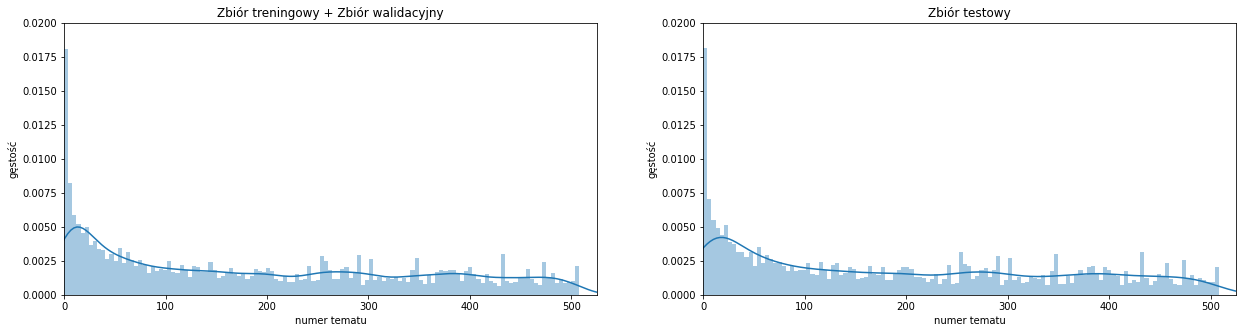

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2, figsize=(21, 5))

df_train = pd.concat([df_comments_train, df_comments_dev])
sns.distplot(df_train['topic'], ax=ax[0], bins=125)
sns.distplot(df_comments_test['topic'], ax=ax[1], bins=125)

ax[0].set_title("Zbiór treningowy + Zbiór walidacyjny")
ax[1].set_title("Zbiór testowy")
ax[0].set_ylabel("gęstość")
ax[1].set_ylabel("gęstość")
ax[0].set_xlabel("numer tematu")
ax[1].set_xlabel("numer tematu")
ax[0].set_ylim(0, 0.02)
ax[1].set_ylim(0, 0.02)
ax[0].set_xlim(0, 525)
ax[1].set_xlim(0, 525)

fig.show()

# rozkład tematów pośród tekstów

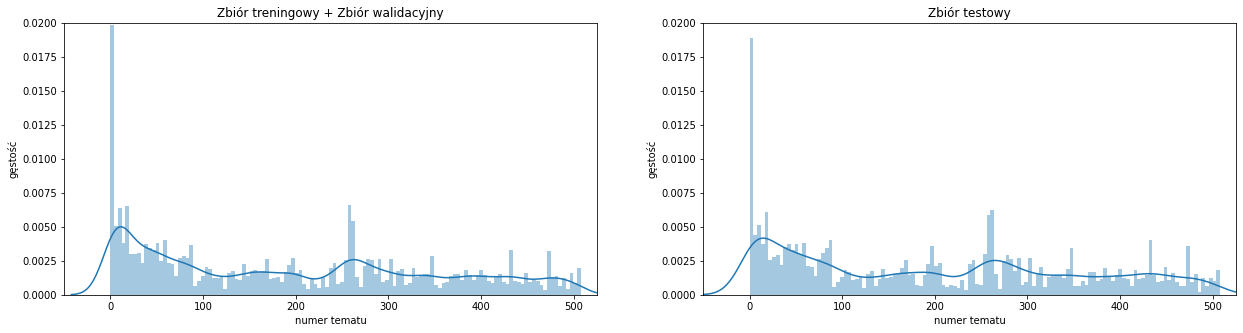

In [ ]:
# rozkład tematów pośród tekstów agresywnych

df_train = pd.concat([df_comments_train, df_comments_dev])
df_anno_comm = df_anno_to_use.merge(df_train, on="rev_id")
df_anno_comm_train_hate = df_anno_comm.loc[df_anno_comm["aggression"] == 1]

df_anno_comm = df_anno_to_use.merge(df_comments_test, on="rev_id")
df_anno_comm_test_hate = df_anno_comm.loc[df_anno_comm["aggression"] == 1]


fig, ax = plt.subplots(1,2, figsize=(21, 5))

sns.distplot(df_anno_comm_train_hate['topic'], ax=ax[0], bins=125)
sns.distplot(df_anno_comm_test_hate['topic'], ax=ax[1], bins=125)

ax[0].set_title("Zbiór treningowy + Zbiór walidacyjny")
ax[1].set_title("Zbiór testowy")
ax[0].set_ylabel("gęstość")
ax[1].set_ylabel("gęstość")
ax[0].set_xlabel("numer tematu")
ax[1].set_xlabel("numer tematu")
ax[0].set_ylim(0, 0.02)
ax[1].set_ylim(0, 0.02)
ax[0].set_xlim(-50, 525)
ax[1].set_xlim(-50, 525)

fig.show()

In [ ]:
min_topic_size = 10

model_name = f"{HOME_PATH}topic_model_{min_topic_size}"
topic_model = BERTopic.load(model_name)

In [ ]:
topic_model.visualize_barchart(top_n_topics=3, n_words=10)


In [ ]:
topic_model.visualize_topics()

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning:

The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.

